In [1]:
import sys
import requests
import tarfile
import json
import numpy as np
from os import path
from PIL import Image
from PIL import ImageFont, ImageDraw
from glob import glob
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import torch
import cv2
from keras.preprocessing.image import ImageDataGenerator
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import os
import shutil

2024-01-26 10:24:29.858701: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-26 10:24:30.170528: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Collecting Labels

In [2]:
with open('/home/voyagerani/Desktop/BrewTex/Datasets/labels/publaynet/train.json', 'r') as f:
    all_labels = json.load(f)

In [3]:
def image_present(image_name):
    return os.path.exists('/home/voyagerani/Desktop/BrewTex/Datasets/train-0/publaynet/train/' + image_name)

image_lables = [image for image in all_labels['images'] if(image_present(image['file_name']))]

# Visualising Labels

In [4]:
import matplotlib.patches as patches

colors = {
    '1' : (255, 0, 0), #Text
    '2' : (0, 255, 0), #Title
    '3' : (0, 0, 255), #List
    '4' : (255, 255, 0), #Table
    '5' : (0, 255, 255) #Figure
}
font = ImageFont.load_default()

def draw_segments(image, annotations):
    draw = ImageDraw.Draw(image, 'RGBA')
    for annotation in annotations:
        #Setting colour
        color = colors[str(annotation['category_id'])]

        #Drawing the bounding boxes
        outline_color = tuple([x/255 for x in colors[str(annotation['category_id'])]]) 
        rect = patches.Rectangle((annotation['bbox'][0], annotation['bbox'][1]), annotation['bbox'][2], annotation['bbox'][3],
                          linewidth = 1, edgecolor = outline_color, facecolor = 'none')

        #Filling the bounding boxes
        draw.polygon(annotation['segmentation'][0], fill = color + (64,))
        
        #Annotate the bounding boxes
        text_label = all_labels['categories'][annotation['category_id'] - 1]['name']

        left, top, right, bottom = font.getbbox(text_label)
        w = abs(right - left)
        h = abs(top - bottom)

        if annotation['bbox'][3] < h:
            draw.rectangle(
                (annotation['bbox'][0] + annotation['bbox'][2],
                 annotation['bbox'][1],
                 annotation['bbox'][0] + annotation['bbox'][2] + w,
                 annotation['bbox'][1] + h),
                fill=(64, 64, 64, 255)
            )
            draw.text(
                (annotation['bbox'][0] + annotation['bbox'][2],
                 annotation['bbox'][1]),
                text=text_label,
                fill=(255, 255, 255, 255),
                font=font
            )
        else:
            draw.rectangle(
                (annotation['bbox'][0],
                 annotation['bbox'][1],
                 annotation['bbox'][0] + w,
                 annotation['bbox'][1] + h),
                fill=(64, 64, 64, 255)
            )
            draw.text(
                (annotation['bbox'][0],
                 annotation['bbox'][1]),
                text=text_label,
                fill=(255, 255, 255, 255),
                font=font
            )
    return np.array(image)

In [5]:
image = Image.open('/home/voyagerani/Desktop/BrewTex/Datasets/train-0/publaynet/train/' + image_lables[0]['file_name'])
annotation_list = [annotation for annotation in all_labels['annotations'] if annotation['image_id'] == image_lables[0]['id']]

In [6]:
image1 = Image.open('/home/voyagerani/Desktop/BrewTex/Datasets/train-0/publaynet/train/' + image_lables[1]['file_name'])
annotation_list1 = [annotation for annotation in all_labels['annotations'] if annotation['image_id'] == image_lables[1]['id']]

In [7]:
# !pip uninstall pillow -y
# !pip install pillow==9.5.0
import PIL
print(PIL.__version__)

9.5.0


In [8]:
labeled_image = draw_segments(image, annotation_list)
labeled_image2 = draw_segments(image1, annotation_list1)

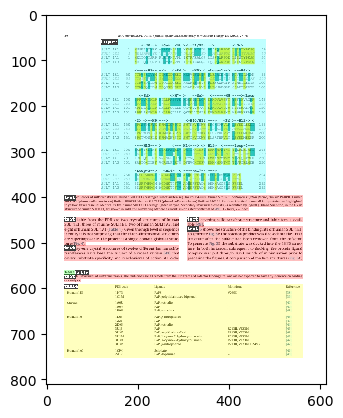

In [9]:
plt.imshow(labeled_image)

In [10]:
import layoutparser as lp

In [11]:
%cd /home/voyagerani/Desktop/BrewTex/layout-parser
model = lp.Detectron2LayoutModel('lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
                                 label_map={0: "text", 1: "title", 2: "list", 3:"table", 4:"figure"})

/home/voyagerani/Desktop/BrewTex/layout-parser


/home/voyagerani/.local/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


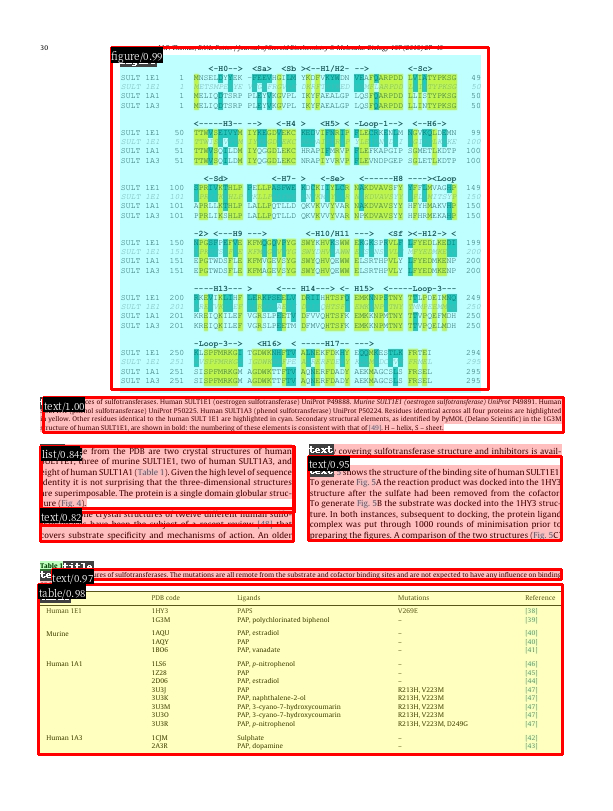

In [12]:
layout_predicted = model.detect(image)
lp.draw_box(image,
              [b.set(id=f'{b.type}/{b.score:.2f}') for b in layout_predicted],
              color_map=colors,
              show_element_id=True, id_font_size=10,
              id_text_background_color='black',
              id_text_color='white')

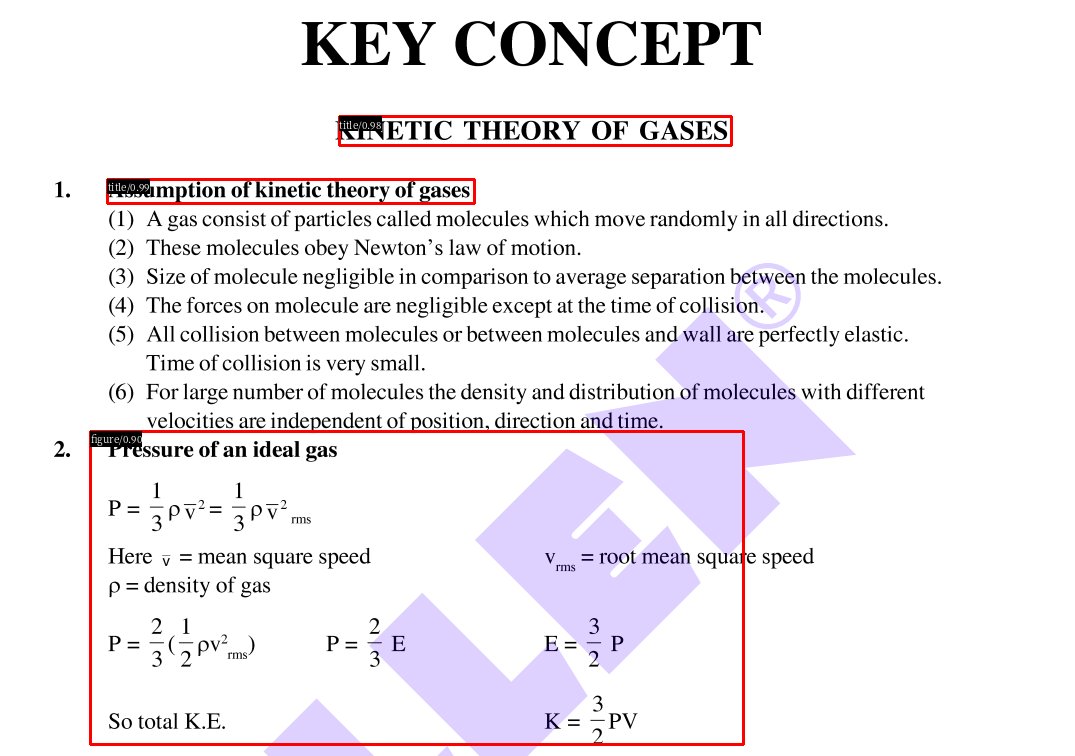

In [13]:
image2 = Image.open('/home/voyagerani/Desktop/BrewTex/AI model/Image augmentation/test1.png')
# plt.imshow(image2)
layout_predicted = model.detect(image2)
lp.draw_box(image2,
              [b.set(id=f'{b.type}/{b.score:.2f}') for b in layout_predicted],
              color_map=colors,
              show_element_id=True, id_font_size=10,
              id_text_background_color='black',
              id_text_color='white')

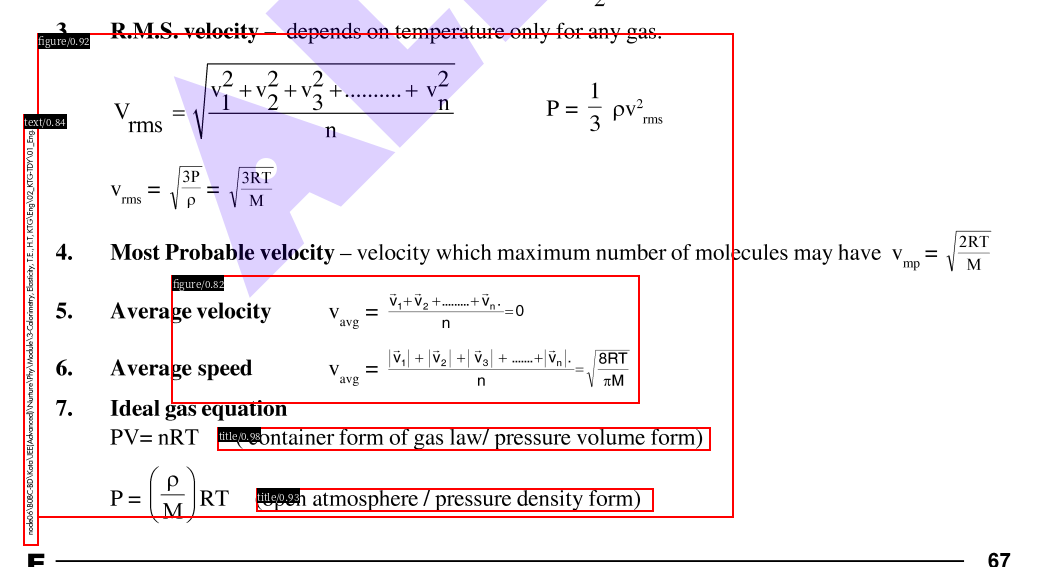

In [14]:
image2 = Image.open('/home/voyagerani/Desktop/BrewTex/AI model/Image augmentation/test2.png')
# plt.imshow(image2)
layout_predicted = model.detect(image2)
lp.draw_box(image2,
              [b.set(id=f'{b.type}/{b.score:.2f}') for b in layout_predicted],
              color_map=colors,
              show_element_id=True, id_font_size=10,
              id_text_background_color='black',
              id_text_color='white')

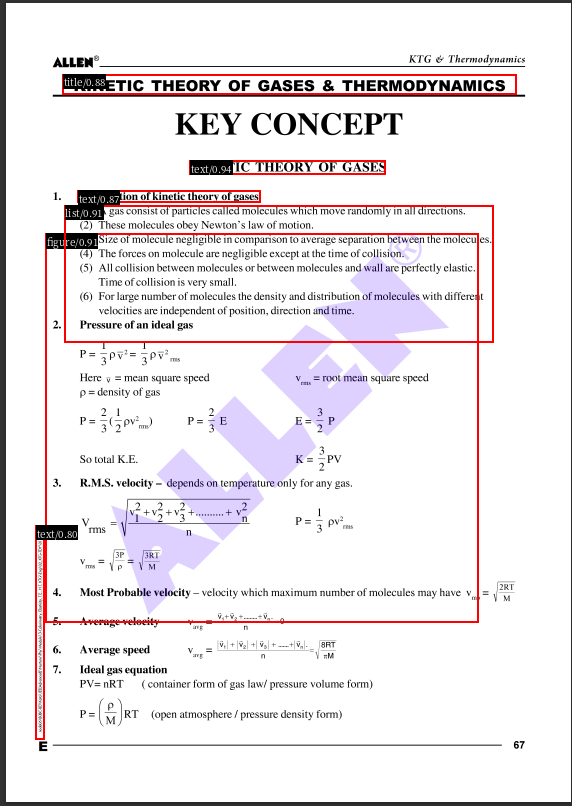

In [15]:
image2 = Image.open('/home/voyagerani/Desktop/BrewTex/AI model/Image augmentation/test3.png')
# plt.imshow(image2)
layout_predicted = model.detect(image2)
lp.draw_box(image2,
              [b.set(id=f'{b.type}/{b.score:.2f}') for b in layout_predicted],
              color_map=colors,
              show_element_id=True, id_font_size=10,
              id_text_background_color='black',
              id_text_color='white')

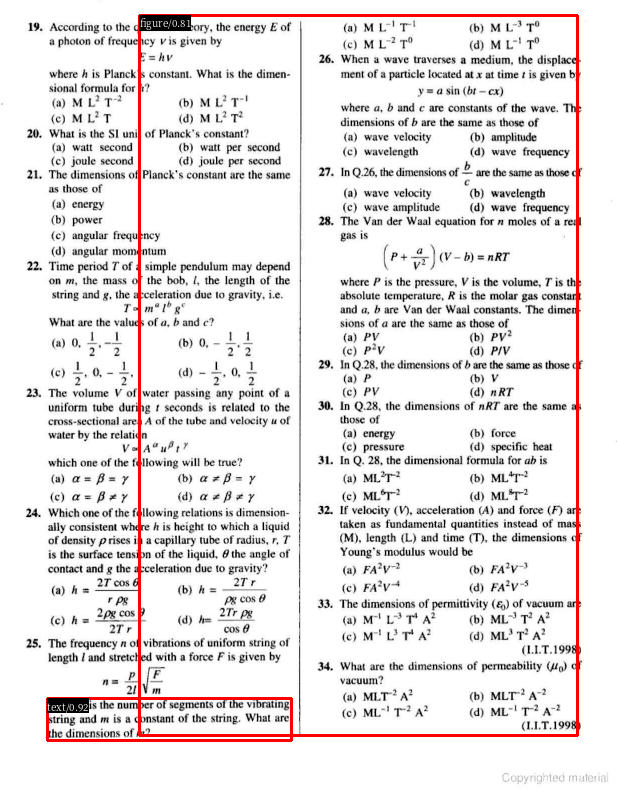

In [16]:
image2 = Image.open('/home/voyagerani/Desktop/BrewTex/AI model/Image augmentation/test4.png')
# plt.imshow(image2)
layout_predicted = model.detect(image2)
lp.draw_box(image2,
              [b.set(id=f'{b.type}/{b.score:.2f}') for b in layout_predicted],
              color_map=colors,
              show_element_id=True, id_font_size=10,
              id_text_background_color='black',
              id_text_color='white')

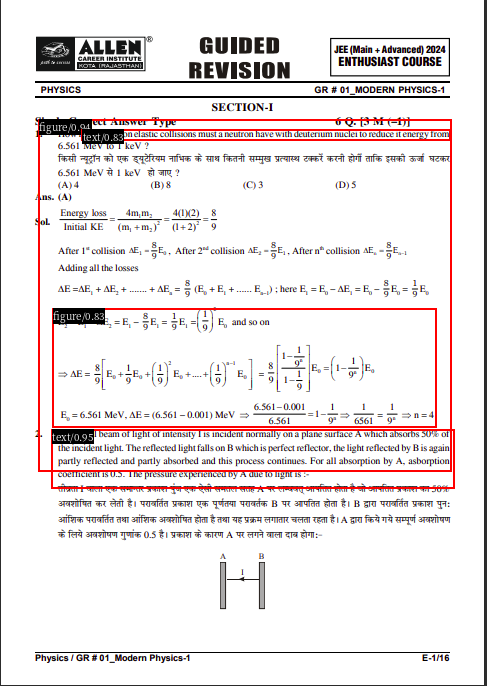

In [17]:
image2 = Image.open('/home/voyagerani/Desktop/BrewTex/AI model/Image augmentation/test5.png')
# plt.imshow(image2)
layout_predicted = model.detect(image2)
lp.draw_box(image2,
              [b.set(id=f'{b.type}/{b.score:.2f}') for b in layout_predicted],
              color_map=colors,
              show_element_id=True, id_font_size=10,
              id_text_background_color='black',
              id_text_color='white')

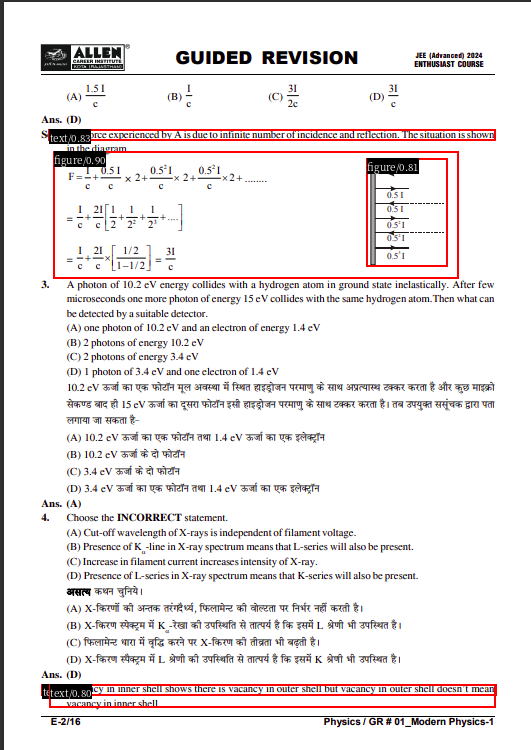

In [18]:
image2 = Image.open('/home/voyagerani/Desktop/BrewTex/AI model/Image augmentation/test6.png')
# plt.imshow(image2)
layout_predicted = model.detect(image2)
lp.draw_box(image2,
              [b.set(id=f'{b.type}/{b.score:.2f}') for b in layout_predicted],
              color_map=colors,
              show_element_id=True, id_font_size=10,
              id_text_background_color='black',
              id_text_color='white')

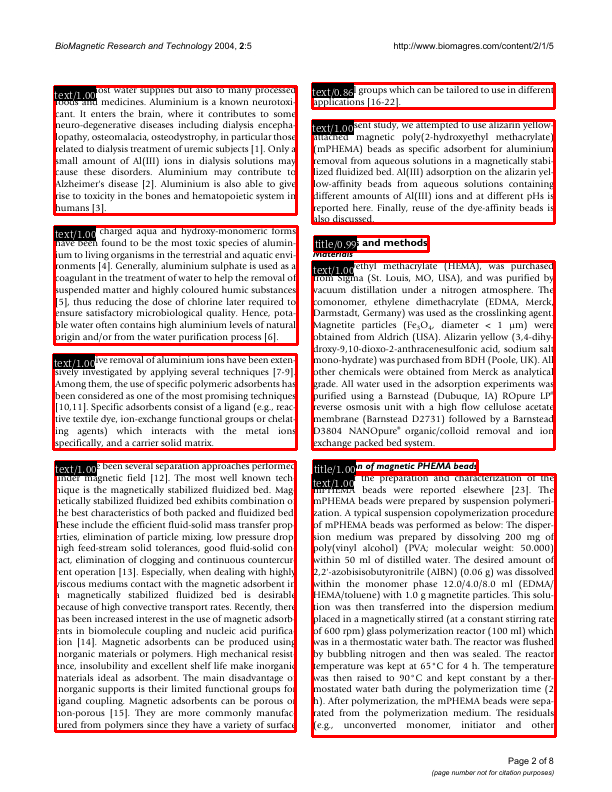

In [19]:
image2 = Image.open('/home/voyagerani/Desktop/BrewTex/Datasets/train-0/publaynet/train/PMC516445_00001.jpg')
# plt.imshow(image2)
layout_predicted = model.detect(image2)
lp.draw_box(image2,
              [b.set(id=f'{b.type}/{b.score:.2f}') for b in layout_predicted],
              color_map=colors,
              show_element_id=True, id_font_size=10,
              id_text_background_color='black',
              id_text_color='white')